In [99]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


### 3. Load and Prepare Data
Load your dataset and prepare it for the LSTM model. This involves parsing dates, normalizing the 'Page.Loads' data, and creating sequences for the LSTM.

In [56]:
# Load dataset
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')

# Convert 'Page.Loads' from string to integer
data['Page.Loads'] = data['Page.Loads'].str.replace(',', '').astype(int)

# Drop unnecessary columns
columns_to_drop = ["Row", "Day", "Day.Of.Week", "Unique.Visits", "Returning.Visits", "First.Time.Visits"]
data.drop(columns=columns_to_drop, inplace=True)

# Initialize and fit the MinMaxScaler on the training data only
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data.loc['2019-01-01':'2019-12-31', ['Page.Loads']])

# Display the first few rows of the dataset
print(data.head())


            Page.Loads
Date                  
2014-09-14        2146
2014-09-15        3621
2014-09-16        3698
2014-09-17        3667
2014-09-18        3316


## 4. Function to Normalize Data and Create Sequences

In [87]:
def prepare_data(data, start_date, end_date, window_size, scaler):
    """
    Normalize data within the start and end date and create LSTM sequences.
    """
    # Filter data for the date range
    data_filtered = data.loc[start_date:end_date, 'Page.Loads'].values.reshape(-1, 1)
    
    # Normalize data using the provided scaler
    data_normalized = scaler.transform(data_filtered)
    
    # Create sequences
    X, y = create_sequences(data_normalized, window_size)
    X = X.reshape((X.shape[0], window_size, 1))
    
    return X, y


## Step 6: Build and Train LSTM Model

In [86]:
def train_model(X_train, y_train, window_size):
    """
    This function builds and trains the LSTM model.
    """
    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    return model


## Step 7: Evaluate Model and Plot Results

In [85]:
def plot_predictions(test, y_test, predicted_test, start_date, end_date, window_size):
    """
    This function plots the actual versus predicted page loads, with a style similar to Prophet's plots.
    """
    # Ensure the test dates are correctly aligned with the length of y_test and predicted_test
    test_dates = test[start_date:end_date].index[window_size:]  # Adjusting the test_dates to match y_test and predicted_test
    
    # Calculate uncertainty (dummy example: 10% of predictions)
    uncertainty = 0.10 * predicted_test.flatten()
    
    # Plot actual vs predicted for the test set
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot actual values
    ax.scatter(test_dates, y_test, color='red', label='Actual')
    
    # Plot predicted values
    ax.plot(test_dates, predicted_test, color='blue', label='Predicted')
    
    # Add a shaded region to represent uncertainty
    ax.fill_between(test_dates, 
                    (predicted_test.flatten() - uncertainty), 
                    (predicted_test.flatten() + uncertainty), 
                    color='blue', alpha=0.2)
    
    # Set the title and labels
    ax.set_title('Page Load Time Prediction (Test Set)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Page Loads')
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Set x-axis and y-axis limits
    ax.set_xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
    ax.set_ylim([0, max(max(y_test), max(predicted_test)) + 1000])
    
    # Rotate date labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


## Making predictions using 2019 training data using window_size 5

Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2956
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1836 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1135 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499  
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0492 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0495 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0449 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0424 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 
Epoch 16/50
12/

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


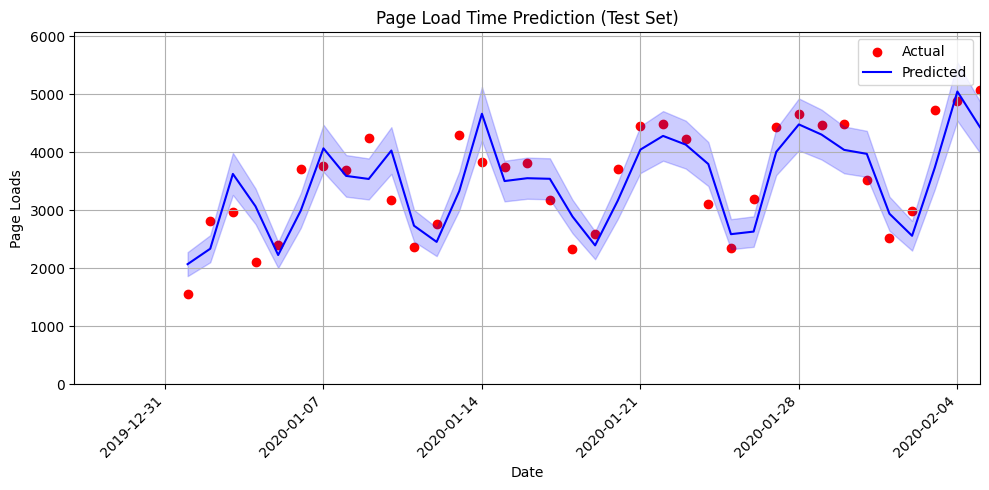

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [97]:
# Define window_size globally if not already done
window_size = 5

# Training data range
training_start_date = '2019-01-01'
training_end_date = '2019-12-26'

# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-27'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-05' # Extend to February 4th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")


## Calculating the MAE, MAPE and MSE

In [103]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 817.4653105981727
Mean Absolute Error (MAE): 658.1950149536133
Mean Absolute Percentage Error (MAPE): 31.191216680586198%


## Making prediction using 2019 data using window_size 1

Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2993
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2901 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2771 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2272 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2192 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1759 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1351 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1199 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0942 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0728 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0619 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0534 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0407
Epoch 16/50
12/12

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


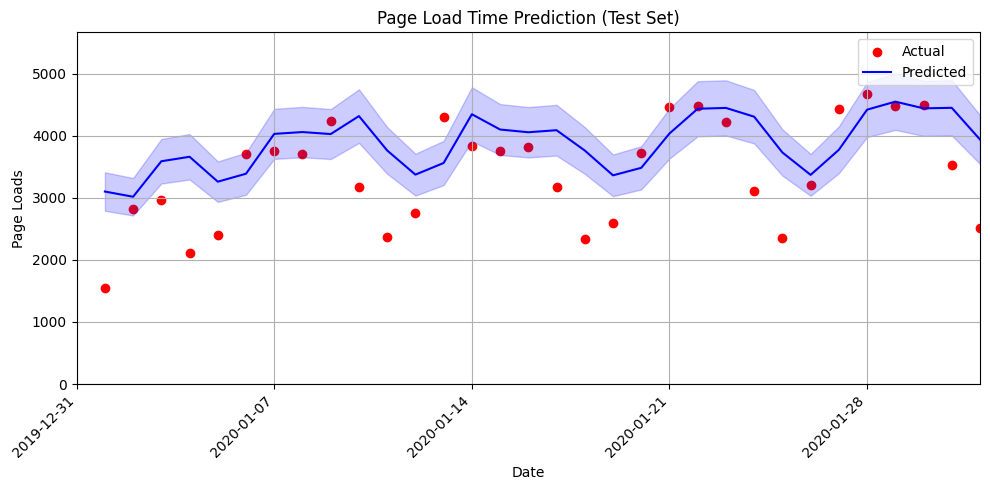

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [98]:
# Define window_size globally if not already done
window_size = 1

# Training data range
training_start_date = '2019-01-01'
training_end_date = '2019-12-30'

# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-31'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-01' # Extend to February 1th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")
